## What do I need to do?

1. Get options data for CMCSA
    - Pick an options expiration date about 30 days from now
    - Get option chain for that expiration
2. Run MC sim on CMCSA
    - Get historical stock price
    - Create distribution
    - Run simulation
3. Calculate the likelihood of hitting each strike price

In [1]:
%matplotlib inline

import math
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
from scipy.stats import genextreme
from random import choices

### Part 1: Get options data for CMCSA

In [2]:
cmcsa = yf.Ticker("CMCSA")

In [3]:
cmcsa.options

('2022-11-18',
 '2022-11-25',
 '2022-12-02',
 '2022-12-09',
 '2022-12-16',
 '2022-12-23',
 '2022-12-30',
 '2023-01-20',
 '2023-04-21',
 '2023-06-16',
 '2024-01-19',
 '2025-01-17')

In [4]:
option_date = '2022-12-16'
start_date = datetime.today().date() - timedelta(days = 1)
start_date = start_date.isoformat()

In [5]:
opt_chain = cmcsa.option_chain(option_date)

In [6]:
opt_chain.calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,CMCSA221216C00025000,2022-11-09 17:31:58+00:00,25.0,7.04,8.85,9.05,0.00,0.000000,2,31,0.644535,True,REGULAR,USD
1,CMCSA221216C00027500,2022-11-10 16:52:23+00:00,27.5,5.30,6.45,6.60,0.00,0.000000,2,11,0.516606,True,REGULAR,USD
2,CMCSA221216C00030000,2022-11-16 18:58:45+00:00,30.0,4.10,4.15,4.30,-0.64,-13.502107,1,6277,0.441412,True,REGULAR,USD
3,CMCSA221216C00032500,2022-11-16 17:43:13+00:00,32.5,2.25,2.17,2.23,-0.20,-8.163267,4,13932,0.362799,True,REGULAR,USD
4,CMCSA221216C00035000,2022-11-16 18:52:26+00:00,35.0,0.80,0.82,0.85,-0.25,-23.809519,619,6727,0.328620,False,REGULAR,USD
5,CMCSA221216C00037500,2022-11-16 18:22:22+00:00,37.5,0.28,0.24,0.28,-0.07,-19.999998,11479,6610,0.336432,False,REGULAR,USD
6,CMCSA221216C00040000,2022-11-16 16:18:04+00:00,40.0,0.11,0.07,0.13,0.01,9.999998,2,4436,0.384772,False,REGULAR,USD
7,CMCSA221216C00042500,2022-11-16 16:31:55+00:00,42.5,0.06,0.03,0.06,0.01,19.999996,2,7,0.419928,False,REGULAR,USD
8,CMCSA221216C00045000,2022-11-15 17:43:50+00:00,45.0,0.03,0.01,0.07,0.00,0.000000,66,65,0.517583,False,REGULAR,USD


### Part 2: Create the MC Sim

In [7]:
hist_price = cmcsa.history(period = "max")
hist_price['Date'] = hist_price.index
hist_price['perc_change'] = (hist_price['Close'] - hist_price['Open']) / hist_price['Open']
hist_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date,perc_change
Date,,,,,,,,,
1980-03-17 00:00:00-05:00,0.000000,0.071825,0.068769,0.068769,138396,0.0,0.0,1980-03-17 00:00:00-05:00,inf
1980-03-18 00:00:00-05:00,0.000000,0.071825,0.068769,0.068769,530518,0.0,0.0,1980-03-18 00:00:00-05:00,inf
1980-03-19 00:00:00-05:00,0.000000,0.071061,0.068004,0.068004,738113,0.0,0.0,1980-03-19 00:00:00-05:00,inf
1980-03-20 00:00:00-05:00,0.000000,0.076410,0.073353,0.073353,1360895,0.0,0.0,1980-03-20 00:00:00-05:00,inf
1980-03-21 00:00:00-05:00,0.000000,0.078702,0.075646,0.075646,461320,0.0,0.0,1980-03-21 00:00:00-05:00,inf
...,...,...,...,...,...,...,...,...,...
2022-11-10 00:00:00-05:00,32.730000,32.900002,32.160000,32.770000,31529100,0.0,0.0,2022-11-10 00:00:00-05:00,0.001222
2022-11-11 00:00:00-05:00,33.130001,34.060001,32.830002,34.020000,24484500,0.0,0.0,2022-11-11 00:00:00-05:00,0.026864
2022-11-14 00:00:00-05:00,33.910000,34.660000,33.810001,34.130001,28778100,0.0,0.0,2022-11-14 00:00:00-05:00,0.006488


<AxesSubplot: xlabel='Date'>

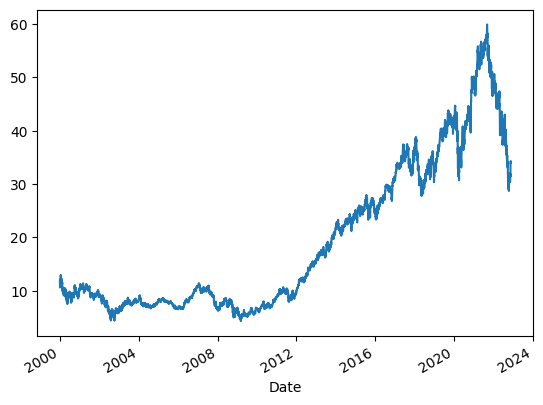

In [8]:
hist_price.loc[hist_price['Date'] >= '2000-01-01', 'Close'].plot()

<AxesSubplot: xlabel='Date'>

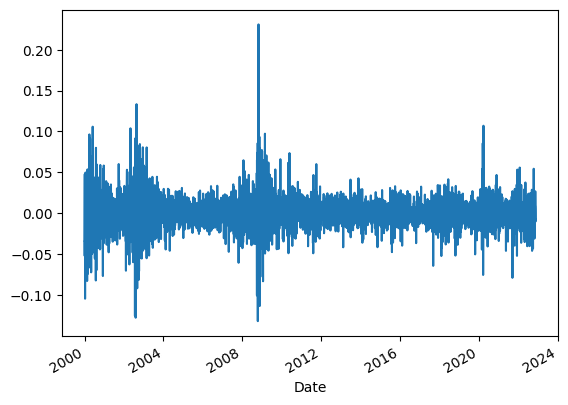

In [9]:
hist_price.loc[hist_price['Date'] >= '2000-01-01', 'perc_change'].plot()

In [10]:
hist_price = hist_price.loc[hist_price['Date'] >= '2000-01-01']

In [11]:
today = datetime.utcnow().date()
start = today - timedelta(days = 90)
end = today

start = start.isoformat()

In [12]:
hist_price.loc[hist_price['Date'] > start]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date,perc_change
Date,,,,,,,,,
2022-08-19 00:00:00-04:00,38.051598,38.448074,37.803802,38.339043,19692200,0.0,0.0,2022-08-19 00:00:00-04:00,0.007554
2022-08-22 00:00:00-04:00,38.289483,38.289483,37.209091,37.288383,21400200,0.0,0.0,2022-08-22 00:00:00-04:00,-0.026146
2022-08-23 00:00:00-04:00,37.318121,37.476711,36.891911,36.911736,16505700,0.0,0.0,2022-08-23 00:00:00-04:00,-0.010890
2022-08-24 00:00:00-04:00,36.881996,37.328030,36.743231,36.782879,17668300,0.0,0.0,2022-08-24 00:00:00-04:00,-0.002687
2022-08-25 00:00:00-04:00,36.961294,37.377589,36.703583,37.268559,21571000,0.0,0.0,2022-08-25 00:00:00-04:00,0.008313
...,...,...,...,...,...,...,...,...,...
2022-11-10 00:00:00-05:00,32.730000,32.900002,32.160000,32.770000,31529100,0.0,0.0,2022-11-10 00:00:00-05:00,0.001222
2022-11-11 00:00:00-05:00,33.130001,34.060001,32.830002,34.020000,24484500,0.0,0.0,2022-11-11 00:00:00-05:00,0.026864
2022-11-14 00:00:00-05:00,33.910000,34.660000,33.810001,34.130001,28778100,0.0,0.0,2022-11-14 00:00:00-05:00,0.006488


In [13]:
perc_pos = (
    sum(hist_price.loc[hist_price['Date'] > start, 'perc_change'] > 0) / 
    len(hist_price.loc[hist_price['Date'] > start, 'perc_change'])
)

perc_neg = 1 - perc_pos

In [14]:
avg = np.mean(hist_price['perc_change'])
std = np.std(hist_price['perc_change'])

In [16]:
sample_size = 20000

upper_scale = 0.60
upper_shape = -0.09

samp_upper = genextreme.rvs(upper_shape, 
                            loc = avg, 
                            scale = upper_scale * std,
                            size = round(sample_size * perc_pos))

In [17]:
lower_scale = 0.65
lower_shape = -0.1

samp_lower = -1 * genextreme.rvs(lower_shape, 
                                 loc = avg, 
                                 scale = lower_scale * std,
                                 size = round(sample_size * perc_neg))

In [18]:
samp = np.append(samp_upper, samp_lower)

(array([1.0000e+00, 0.0000e+00, 2.0000e+00, 1.3000e+01, 9.7000e+01,
        1.0820e+03, 1.4094e+04, 4.4900e+03, 2.0100e+02, 2.0000e+01]),
 array([-0.26566968, -0.22659122, -0.18751277, -0.14843431, -0.10935586,
        -0.07027741, -0.03119895,  0.0078795 ,  0.04695796,  0.08603641,
         0.12511487]),
 <BarContainer object of 10 artists>)

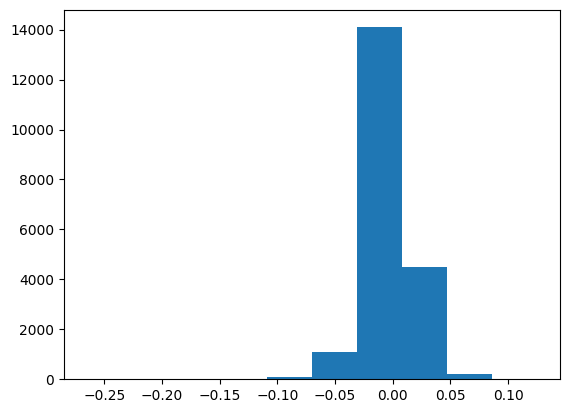

In [19]:
plt.hist(samp)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb674530940>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb674530e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb67468bdf0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb6745313c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb674531660>],
 'means': []}

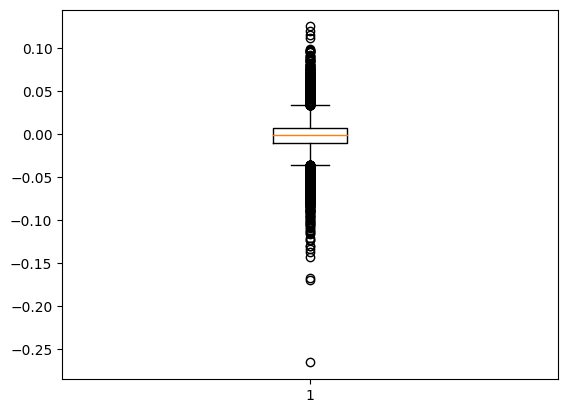

In [20]:
plt.boxplot(samp)

(array([6.000e+00, 2.800e+01, 3.620e+02, 4.387e+03, 8.960e+02, 6.800e+01,
        8.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.13178767, -0.09553199, -0.0592763 , -0.02302061,  0.01323507,
         0.04949076,  0.08574644,  0.12200213,  0.15825782,  0.1945135 ,
         0.23076919]),
 <BarContainer object of 10 artists>)

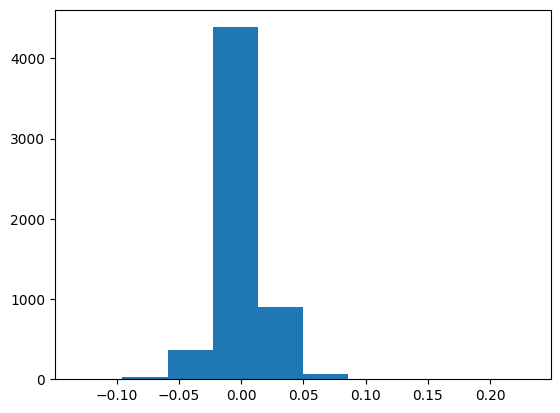

In [21]:
plt.hist(hist_price['perc_change'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb640efded0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb640efe410>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb640efdc30>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb640efe950>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb640efebf0>],
 'means': []}

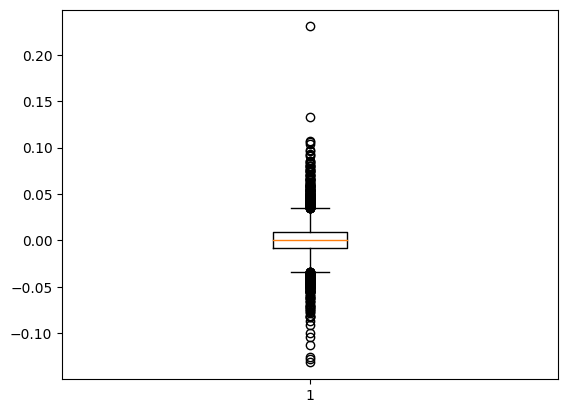

In [22]:
plt.boxplot(hist_price['perc_change'])

In [23]:
date = {"Date": pd.date_range(datetime.today().date(), option_date)}

dates = pd.DataFrame(data = date)
dates['wday'] = dates['Date'].dt.dayofweek
dates = dates.loc[dates['wday'] != 5]
dates = dates.loc[dates['wday'] != 6]

num_samples = 10000
num_trading_days = dates.shape[0]

sample_col = pd.Series(range(1,num_trading_days+1)).repeat(num_samples)
dates_col = dates['Date'].repeat(num_samples)
sample_values = np.array(choices(samp + 1, k = num_samples * num_trading_days)).reshape(num_trading_days, num_samples)

start_price = hist_price.loc[hist_price['Date'] == start_date, 'Close']

sample_values[0] = start_price

# mc_dat = pd.DataFrame({'Date': dates_col, 'sample': sample_col, 'perc_change': sample_values})

In [24]:
price_paths = sample_values.cumprod(axis = 0)

 ...]

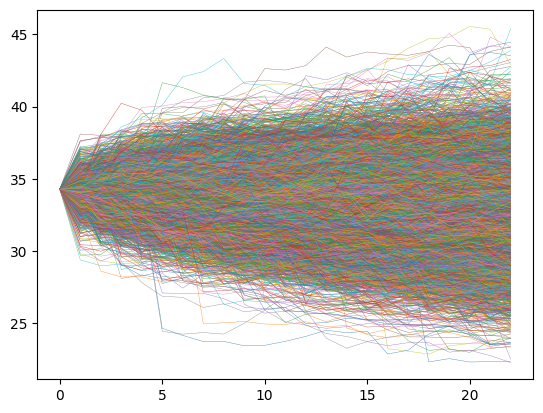

In [25]:
plt.plot(price_paths, linewidth = 0.25)

In [29]:
final_prices = price_paths[num_trading_days - 1]

for strp in opt_chain.puts.strike:
    print(f'There is a {round((sum(final_prices < strp) / num_samples) * 100, 2)}% chance that CMCSA is below {strp} on {option_date}')

There is a 0.0% chance that CMCSA is below 17.5 on 2022-12-16
There is a 0.0% chance that CMCSA is below 20.0 on 2022-12-16
There is a 0.03% chance that CMCSA is below 22.5 on 2022-12-16
There is a 0.38% chance that CMCSA is below 25.0 on 2022-12-16
There is a 3.37% chance that CMCSA is below 27.5 on 2022-12-16
There is a 17.02% chance that CMCSA is below 30.0 on 2022-12-16
There is a 47.61% chance that CMCSA is below 32.5 on 2022-12-16
There is a 79.56% chance that CMCSA is below 35.0 on 2022-12-16
There is a 95.09% chance that CMCSA is below 37.5 on 2022-12-16
There is a 99.31% chance that CMCSA is below 40.0 on 2022-12-16
There is a 99.88% chance that CMCSA is below 42.5 on 2022-12-16


In [30]:
opt_chain.puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,CMCSA221216P00017500,2022-11-07 19:17:11+00:00,17.5,0.02,0.00,0.03,0.00,0.000000,15,97,0.921876,False,REGULAR,USD
1,CMCSA221216P00020000,2022-11-14 17:29:35+00:00,20.0,0.03,0.00,0.03,0.00,0.000000,2,569,0.750003,False,REGULAR,USD
2,CMCSA221216P00022500,2022-11-09 20:22:09+00:00,22.5,0.06,0.01,0.04,0.00,0.000000,15,25,0.640629,False,REGULAR,USD
3,CMCSA221216P00025000,2022-11-16 18:58:04+00:00,25.0,0.07,0.03,0.06,0.00,0.000000,9,5236,0.539067,False,REGULAR,USD
4,CMCSA221216P00027500,2022-11-16 18:57:55+00:00,27.5,0.13,0.10,0.13,0.03,29.999992,20,9990,0.484380,False,REGULAR,USD
5,CMCSA221216P00030000,2022-11-16 19:05:52+00:00,30.0,0.29,0.27,0.30,0.00,0.000000,10900,9294,0.410162,False,REGULAR,USD
6,CMCSA221216P00032500,2022-11-16 18:28:58+00:00,32.5,0.72,0.74,0.77,0.00,0.000000,314,5909,0.354499,False,REGULAR,USD
7,CMCSA221216P00035000,2022-11-16 18:53:56+00:00,35.0,1.97,1.87,1.92,0.24,13.872832,198,7494,0.328620,True,REGULAR,USD
8,CMCSA221216P00037500,2022-10-31 14:22:52+00:00,37.5,6.11,3.80,3.90,0.00,0.000000,1,7,0.356452,True,REGULAR,USD
9,CMCSA221216P00040000,2022-10-21 15:30:33+00:00,40.0,9.80,6.15,6.30,0.00,0.000000,2,0,0.444341,True,REGULAR,USD


In [ ]:
for strp in opt_chain.calls.strike:
    print(f'There is a {round((sum(final_prices > strp) / num_samples) * 100, 2)}% chance that CMCSA is above {strp} on {option_date}')

In [ ]:
opt_chain.calls